In [2]:
import warnings
import glob
import os

import mne

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

In [3]:
mne.set_log_level("CRITICAL")

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.linear_model._logistic')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='mne')

https://physionet.org/content/ltrsvp/1.0.0/5-Hz/#files-panel

In [4]:
base_dir = 'data'

In [5]:
files = sorted(glob.glob(os.path.join(base_dir, "*.edf")))

print(files)

['data/rsvp\\rsvp_5Hz_02a.edf', 'data/rsvp\\rsvp_5Hz_02b.edf', 'data/rsvp\\rsvp_5Hz_13a.edf', 'data/rsvp\\rsvp_5Hz_13b.edf', 'data/rsvp\\rsvp_5Hz_14a.edf', 'data/rsvp\\rsvp_5Hz_14b.edf']


In [6]:
raw_list = []

for file in files:
    try:
        print(f"Loading: {file}")
        raw = mne.io.read_raw_edf(file, preload=True)
        #print(f"Annotations found: {len(raw.annotations)}")
        raw_list.append(raw)
    except Exception as e:
        print(f"Load error {file}:")
        print(e)

raw = mne.concatenate_raws(raw_list)

Loading: data/rsvp\rsvp_5Hz_02a.edf
Loading: data/rsvp\rsvp_5Hz_02b.edf
Loading: data/rsvp\rsvp_5Hz_13a.edf
Loading: data/rsvp\rsvp_5Hz_13b.edf
Loading: data/rsvp\rsvp_5Hz_14a.edf
Loading: data/rsvp\rsvp_5Hz_14b.edf


<Info | 8 non-empty values
 bads: []
 ch_names: EEG PO8, EEG PO7, EEG P8, EEG P7, EEG O1, EEG O2, EEG PO3, EEG ...
 chs: 9 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 28.0 Hz
 meas_date: 2013-02-06 22:49:26 UTC
 nchan: 9
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 3 items (dict)
>


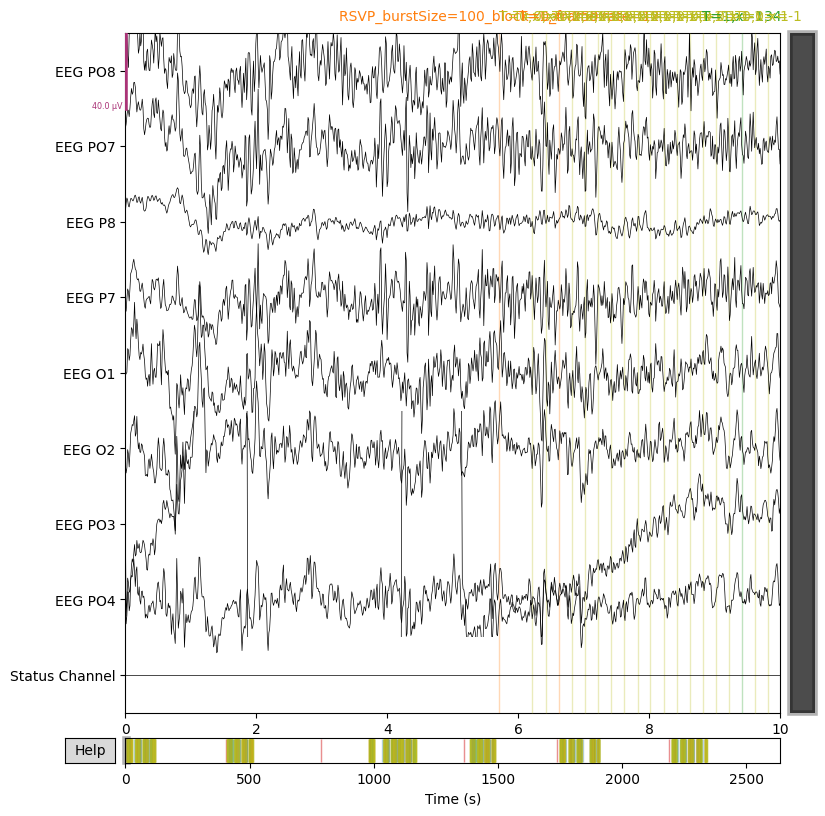

In [7]:
print(raw.info)

raw.plot();

In [8]:
print("\nUnique annotation descriptions:")
unique_descriptions = set(raw.annotations.description)
print(unique_descriptions)


Unique annotation descriptions:
{'T=1,x=389', 'T=1,x=278', 'T=1,x=173', 'T=1,x=413', 'T=1,x=342', 'T=1,x=502', 'T=1,x=363', 'T=1,x=375', 'T=1,x=299', 'T=1,x=194', 'T=1,x=158', 'T=1,x=315', 'END', 'T=1,x=282', 'T=1,x=285', 'T=1,x=450', 'T=1,x=447', 'T=1,x=327', 'T=1,x=308', 'T=1,x=287', 'T=1,x=188', 'T=1,x=201', 'T=1,x=368', 'T=1,x=386', 'T=1,x=306', 'T=1,x=317', 'RSVP_burstSize=100_block=5_frame rate=12', 'T=1,x=434', 'T=1,x=505', 'T=1,x=262', 'RSVP_burstSize=100_block=2_frame rate=12', 'T=1,x=425', 'T=1,x=406', 'T=1,x=366', 'T=1,x=125', 'T=1,x=181', 'T=1,x=187', 'T=1,x=331', 'T=1,x=130', 'T=1,x=235', 'RSVP_burstSize=100_block=4_frame rate=12', 'T=1,x=157', 'T=1,x=382', 'T=1,x=196', 'T=1,x=417', 'T=1,x=135', 'T=1,x=400', 'T=1,x=268', 'T=1,x=509', 'T=1,x=202', 'T=1,x=146', 'T=1,x=190', 'T=1,x=364', 'T=1,x=441', 'T=1,x=446', 'T=1,x=380', 'T=1,x=290', 'RSVP_burstSize=100_block=3_frame rate=12', 'T=1,x=186', 'T=1,x=376', 'BAD boundary', 'T=1,x=370', 'T=1,x=480', 'T=1,x=263', 'T=1,x=490', 

In [9]:
new_descriptions = []
new_onsets = []
new_durations = []

for desc, onset, duration in zip(raw.annotations.description,
                               raw.annotations.onset,
                               raw.annotations.duration):
    if desc.startswith('T=0'):
        new_descriptions.append('T=0')
        new_onsets.append(onset)
        new_durations.append(duration)
    elif desc.startswith('T=1'):
        new_descriptions.append('T=1')
        new_onsets.append(onset)
        new_durations.append(duration)

In [10]:
filtered_annotations = mne.Annotations(
    onset=new_onsets,
    duration=new_durations,
    description=new_descriptions
)

raw_filtered = raw.copy()
raw_filtered.set_annotations(filtered_annotations)

print(raw_filtered.annotations)

<Annotations | 2587 segments: T=0 (2332), T=1 (255)>


In [11]:
raw_filtered.filter(l_freq=1, h_freq=40)

<RawEDF | rsvp_5Hz_02a.edf, 9 x 5400576 (2637.0 s), ~370.8 MB, data loaded>

Event info:


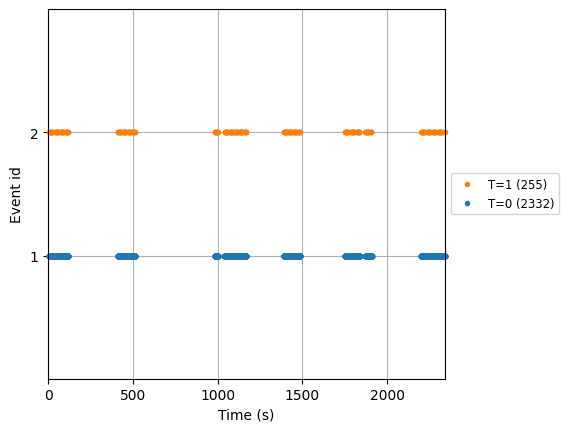

In [12]:
events, event_id = mne.events_from_annotations(raw_filtered)

print("Event info:")

fig = mne.viz.plot_events(events, event_id=event_id, 
                         sfreq=raw_filtered.info['sfreq'])
plt.show()

In [13]:
tmin = -0.2
tmax = 0.5

epochs = mne.Epochs(raw_filtered, events, event_id=event_id,
                   tmin=tmin, tmax=tmax,
                   baseline=(None, 0),
                   preload=True)

print(epochs)

<Epochs | 2587 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~254.9 MB, data loaded,
 'T=0': 2332
 'T=1': 255>


In [14]:
X = epochs.get_data().astype('float64')
y = epochs.events[:, -1]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [24]:
sca_pca_mlp = Pipeline([
    ('scaler', StandardScaler()),               
    ('pca', PCA(n_components=5)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100))
])

display(sca_pca_mlp)

sca_pca_mlp.fit(X_train_flattened, y_train)

train_accuracy = sca_pca_mlp.score(X_train_flattened, y_train)
test_accuracy = sca_pca_mlp.score(X_test_flattened, y_test)

print(f"Test accuracy: {test_accuracy:.2f}")


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100))])

Test accuracy: 0.88
